# Proyecto N°1: Clasificación con método _Bag of Features_

This project will be evaluated in class groups. The evaluation metrics are based on your presentation and code provided in your attachments. Your solutions to the following problem should include commented source code written in Python. You can use additional modules if necessary. Analyze your results. If you discover something interesting, let us know!

The past decade has seen the growing popularity of Bag of Features (BoF) approaches to many computer vision tasks, including image classification, video search, robot localization, and texture recognition. Part of the appeal is simplicity. BoF methods are based on orderless collections of quantized local image descriptors; they discard spatial information and are therefore conceptually and computationally simpler than many alternative methods [here](https://arxiv.org/pdf/1101.3354.pdf).

For this project, you have to implement the Bag of Features representation for a classification problem. To accomplish this, execute the following tasks in the given order:

1. Download CIFAR-10 dataset [here](https://www.kaggle.com/c/cifar-10/data). You have to select at least 4 classes to classify.
2. For each image, compute Bag of features descriptors.
3. Select a classifier using the BoF as input data, Options are Neural Network and KNN
4. Evaluate the classifier using the testing set.
5. Compute performance metrics creating a confusion matrix.

For **task #3**, you have to read and implement the approach presented [here](https://arxiv.org/pdf/1101.3354.pdf), and you can look for additional information on internet. For **task #6** you should measure model performance with unseen data for this classification problem.

### 1. Importación de módulos y librerias.

In [134]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier



### 2. Selección de imagenes de entrenamiento (4 categorías).

#### 2.A Lectura del archivo de etiquetas .csv (_Comma separated values_)

In [2]:
# Abrimos el archivo e imprimimos la cabecera para verificar.
filename = 'trainLabels.csv'
labels = pd.read_csv(filename)
print(labels.head())

   id       label
0   1        frog
1   2       truck
2   3       truck
3   4        deer
4   5  automobile


#### 2.B Lectura de carpeta con imagenes

In [3]:
# Ruta de la carpeta con los archivos
path = 'train'
train_set = os.listdir(path)
print('Lista de imagenes de entrenamiento - Clase "{}" | Tamaño: {}'.format(type(train_set).__name__, len(train_set)))
print(train_set[0:5])

Lista de imagenes de entrenamiento - Clase "list" | Tamaño: 50000
['1.png', '10.png', '100.png', '1000.png', '10000.png']


#### 2.C Selección de imagenes en base a etiquetas elegidas.

In [222]:
# Lista de categorias seleccionadas
categorias = ['cat', 'frog', 'truck', 'ship']

# Filtro en base a las categorias.
train_list = labels.loc[labels['label'].isin(categorias)]['id'].tolist()
print('Tamaño del set de entrenamiento en base a categorías: {}'.format(len(train_list)))
train_labels = labels.loc[labels['label'].isin(categorias)]['label'].tolist()
print(train_labels[0])

for i in range (len(train_labels)):
    if train_labels[i] == 'cat' :
        train_labels[i] = '1'
    if train_labels[i] == 'frog' :
        train_labels[i] = '2'    
    if train_labels[i] == 'truck' :
        train_labels[i] = '3'
    if train_labels[i] == 'ship' :
        train_labels[i] = '4'
        
        
print(train_labels[0:20])

array_labels = np.asarray(train_labels)

print(array_labels[0:20])

Tamaño del set de entrenamiento en base a categorías: 20000
frog
['2', '3', '3', '4', '1', '3', '3', '3', '1', '2', '1', '2', '2', '2', '1', '3', '1', '1', '1', '1']
['2' '3' '3' '4' '1' '3' '3' '3' '1' '2' '1' '2' '2' '2' '1' '3' '1' '1'
 '1' '1']


### 3. _Bag of Features_ (Descriptor)

In [220]:
# Creamos nuestra lista de vectores con los descriptores.
des_list = []

# Si desea probar sobre un tamaño pequeño de la lista de entrenamiento, edite la variable len_train
len_train = 20
label_count = 0
for img_item in train_list[0:len_train] :
    # Creamos nuestro elemento SIFT por cada imagen
    img_path = os.path.join(path, str(img_item)+'.png')
    img  = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculo de los descriptores y los puntos clave (Keypoints)
    train_labels = np.append(train_labels, label_count)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)
    # Guardamos dicho array en la lista
    des_list.append(des)
    label_count += 1

train_labels = train_labels[0:len_train]

print(train_list[0:20])
# Matriz n x 128 por cada descriptor
des_shape = [v.shape[0] for v in des_list]
print('Tamaño aproximado de descriptores por imagen: {}'.format(np.mean(des_shape)))

[1, 2, 3, 9, 10, 15, 16, 17, 18, 20, 22, 23, 24, 26, 27, 32, 34, 37, 39, 40]
Tamaño aproximado de descriptores por imagen: 14.55


In [6]:
# Organizamos todos los descriptores en una sola matriz.
des_stack = np.vstack(des_list)
print('Tamaño total de descriptores: {}'.format(des_stack.shape))

Tamaño total de descriptores: (296, 128)


### 4. Clasificador por método _K-means clustering_

#### 4.A K-means

In [26]:
# Método k-means clustering
k = 15 # Número de grupos (clusters)
kmeans_ret = KMeans(n_clusters = k).fit_predict(des_stack)
print('Número de grupos: {} | Tamaño del vocabulario generado: {}'.format(k, len(kmeans_ret)))

Número de grupos: 15 | Tamaño del vocabulario generado: 296


#### 4.B Histograma

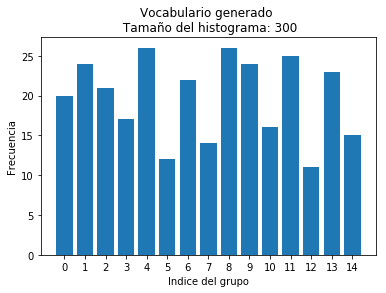

(20, 15)


In [176]:
# Generamos un histograma vacio en base al tamaño de grupos.
histograma = np.array([np.zeros(k) for i in range(len_train)])
# Contador para guardar el indice del grupo (cluster).
old_count = 0

# Iterando en nuestro conjunto de prueba.
for i in range(len_train):
    # Para cada imagen, obtengase el descriptor asociado.
    p = len(des_list[i])
    # Para cada descriptor de dicha imagen, obtengase su grupo asociado.
    for j in range(p):
        idx = kmeans_ret[old_count+j]
        histograma[i][idx] += 1
    old_count += p
x_scalar = np.arange(k)
y_scalar = np.array([abs(np.sum(histograma[:,h])) for h in range(k)])

# Realizamos el gráfico del histograma
plt.bar(x_scalar, y_scalar)
plt.xlabel("Indice del grupo")
plt.ylabel("Frecuencia")
plt.title("Vocabulario generado \n Tamaño del histograma: {}".format(histograma.size))
plt.xticks(x_scalar, x_scalar)
plt.show()


train_data = histograma
print(train_data.shape)


### 5. Entrenamiento

In [161]:
#Tf-Idf 
nbr_occurences = np.sum( (histograma > 0) * 1, axis = 0)
# Calcular número de ocurrencias
idf = np.array(np.log((1.0*len(train_list)+1) / (1.0*nbr_occurences + 1)), 'float32')
# Dando más peso a las más frecuentes
print(idf)
train_data = train_data.astype(np.float32)
train_labels = train_labels.astype(np.float32)

stdSlr = StandardScaler().fit(train_data)
train_data = stdSlr.transform(train_data)  
print(type(train_labels))
# Entrenando el clasificador con los datos de entrenamiento
knn = cv2.ml.KNearest_create()
knn.train(train_data,cv2.ml.ROW_SAMPLE,train_labels)


[7.0703244 7.5056424 7.1954875 7.338588  7.338588  7.706313  7.26448
 7.5056424 7.338588  7.418631  7.5056424 7.130949  7.706313  7.26448
 7.6009526]
<class 'numpy.ndarray'>


True

### 6. Clasificación 

In [217]:
# Para el proceso de clasificación, se repite el mismo procedimiento de extracción de características 
# teniendo como referencia, el set de pruebas
# Ruta de la carpeta con los archivos
path = 'test'
test_set = os.listdir(path)
print('Lista de imagenes de entrenamiento - Clase "{}" | Tamaño: {}'.format(type(test_set).__name__, len(test_set)))

# Creamos nuestra lista de vectores con los descriptores.
des_test = []

# Si desea probar sobre un tamaño pequeño de la lista de prueba, edite la variable len_test
len_test = 20
test_count = 0
for img_item in test_set[0:len_test] :
    # Creamos nuestro elemento SIFT por cada imagen
    img_path = os.path.join(path, str(img_item))
    img  = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculo de los descriptores y los puntos clave (Keypoints)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray,None)
    # Guardamos dicho array en la lista
    des_test.append(des)
    label_count += 1
    

    
test_set= np.asarray(test_set)
print(sorted(test_set[0:20]))




Lista de imagenes de entrenamiento - Clase "list" | Tamaño: 300000
['1.png', '10.png', '100.png', '1000.png', '10000.png', '100000.png', '100001.png', '100002.png', '100003.png', '100004.png', '100005.png', '100006.png', '100007.png', '100008.png', '100009.png', '10001.png', '100010.png', '100011.png', '100012.png', '100013.png']


In [170]:
# Organizamos todos los descriptores en una sola matriz.
test_stack = np.vstack(des_test)
print('Tamaño total de descriptores: {}'.format(test_stack.shape))

Tamaño total de descriptores: (243, 128)


In [172]:
# Método k-means clustering
k = 15 # Número de grupos (clusters)
kmeans_test = KMeans(n_clusters = k).fit_predict(test_stack)
print('Número de grupos: {} | Tamaño del vocabulario generado: {}'.format(k, len(kmeans_test)))

Número de grupos: 15 | Tamaño del vocabulario generado: 243


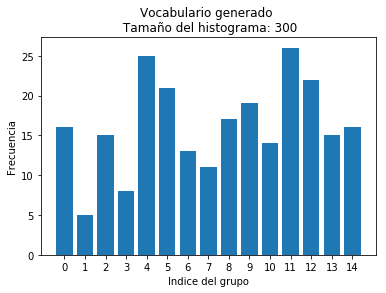

(20, 15)


In [177]:
# Generamos un histograma vacio en base al tamaño de grupos.
histograma_test = np.array([np.zeros(k) for i in range(len_test)])
# Contador para guardar el indice del grupo (cluster).
test_count = 0

# Iterando en nuestro conjunto de prueba.
for i in range(len_test):
    # Para cada imagen, obtengase el descriptor asociado.
    p = len(des_test[i])
    # Para cada descriptor de dicha imagen, obtengase su grupo asociado.
    for j in range(p):
        idx = kmeans_test[test_count+j]
        histograma_test[i][idx] += 1
    test_count += p
x_test = np.arange(k)
y_test = np.array([abs(np.sum(histograma_test[:,h])) for h in range(k)])

# Realizamos el gráfico del histograma
plt.bar(x_test, y_test)
plt.xlabel("Indice del grupo")
plt.ylabel("Frecuencia")
plt.title("Vocabulario generado \n Tamaño del histograma: {}".format(histograma_test.size))
plt.xticks(x_test, x_test)
plt.show()

test_data = histograma_test
print(train_data.shape)

In [219]:
#Tf-Idf 
nbr_occurences = np.sum( (histograma > 0) * 1, axis = 0)
# Calcular número de ocurrencias
idf = np.array(np.log((1.0*len(test_set)+1) / (1.0*nbr_occurences + 1)), 'float32')
# Dando más peso a las más frecuentes
test_data = test_data.astype(np.float32)

ret, results, neighbours, dist = knn.findNearest(test_data, k)

print('Categorías=')
# ['cat', 'frog', 'truck', 'ship']
print('1 para cat'); print('2 para frog'); print('3 para truck'); print('4 para ship')

for i in range (len_test):
    print (("resultado: {} para imagen{}").format(results[i],test_set[i]))

print ("vecinos: ", neighbours,"\n")



Categorías=
1 para cat
2 para frog
3 para truck
4 para ship
resultado: [1.] para imagen1.png
resultado: [1.] para imagen10.png
resultado: [1.] para imagen100.png
resultado: [1.] para imagen1000.png
resultado: [1.] para imagen10000.png
resultado: [1.] para imagen100000.png
resultado: [1.] para imagen100001.png
resultado: [1.] para imagen100002.png
resultado: [1.] para imagen100003.png
resultado: [3.] para imagen100004.png
resultado: [1.] para imagen100005.png
resultado: [1.] para imagen100006.png
resultado: [1.] para imagen100007.png
resultado: [1.] para imagen100008.png
resultado: [1.] para imagen100009.png
resultado: [1.] para imagen10001.png
resultado: [1.] para imagen100010.png
resultado: [1.] para imagen100011.png
resultado: [1.] para imagen100012.png
resultado: [1.] para imagen100013.png
vecinos:  [[2. 1. 3. 1. 2. 4. 3. 1. 3. 1. 2. 3. 1. 1. 3.]
 [1. 3. 2. 2. 1. 3. 1. 1. 1. 4. 2. 3. 2. 1. 3.]
 [2. 2. 3. 4. 3. 1. 1. 1. 2. 1. 1. 1. 2. 3. 1.]
 [1. 2. 4. 1. 1. 2. 2. 3. 2. 3. 1. 2. 3. 1